This notebook is to analyze the automatic detection tools against human annotation.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import ast
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import spacy
from nltk.stem import PorterStemmer

In [2]:
# Load spaCy English model
nlp = spacy.load("en_core_web_sm")
stemmer = PorterStemmer()

/home/mila/c/clea.chataigner/multi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#Config
modifications=['prepositions', 'synonym_substitution', 'change_voice', 'AAE', 'formal'] 
models=['chatgpt', "deepseek"]

# Data importation

In [32]:
all_dfs=[]
for modification in modifications:
    DATA_FOLDER=f'../data/paraphrases/{modification}/'
    for model in models:
        ANNOTATED_FILE=DATA_FOLDER+f"Gender_identity_{modification}_{model}_annotated.xlsx"
        model_df=pd.read_excel(ANNOTATED_FILE)
        model_df['model'] = model  # Add model column
        model_df['unique_id'] = model_df['idx'].astype(str) + '_' + model_df['disambiguated'].astype(str)
        print(f"Number of settings without paraphrases for {model} and modification {modification}:", 120-len(model_df.unique_id.unique()))
        all_dfs.append(model_df)
all_annotated_df=pd.concat(all_dfs, ignore_index=True)

Number of settings without paraphrases for chatgpt and modification prepositions: 0
Number of settings without paraphrases for deepseek and modification prepositions: 3
Number of settings without paraphrases for chatgpt and modification synonym_substitution: 0
Number of settings without paraphrases for deepseek and modification synonym_substitution: 0
Number of settings without paraphrases for chatgpt and modification change_voice: 5
Number of settings without paraphrases for deepseek and modification change_voice: 0
Number of settings without paraphrases for chatgpt and modification AAE: 0
Number of settings without paraphrases for deepseek and modification AAE: 0
Number of settings without paraphrases for chatgpt and modification formal: 0
Number of settings without paraphrases for deepseek and modification formal: 0


In [33]:
def safe_eval(val):
    if pd.isna(val):
        return np.nan  # or return [] if you prefer empty list
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return np.nan  # or [] for robustness

In [34]:
#Cleaning
all_annotated_df["keep"]=all_annotated_df["keep"].map({'y': True, 'n':False, True:True, False:False})
all_annotated_df["keep"]=all_annotated_df["keep"].astype(bool)
all_annotated_df["wrong_added"]=all_annotated_df["wrong_added"].apply(safe_eval)
all_annotated_df["wrong_removed"]=all_annotated_df["wrong_removed"].apply(safe_eval)
all_annotated_df["proba_par"]=all_annotated_df["proba_par"].apply(lambda x : round(x,2))
all_annotated_df["proba_ori"]=all_annotated_df["proba_ori"].apply(lambda x : round(x,2))

In [35]:
all_annotated_df.head()

,idx,Q_id,disambiguated,modification,keep,original,raw_answer,nb_modif,wrong_modif,realism,...,label_ori,label_par,proba_ori,proba_par,Unnamed: 15,ratio,Completed:,1,template,Unnamed: 16
0,0,1,False,prepositions,True,We couldn't start the board meeting at 9am tod...,We couldn't start the board meeting by 9am tod...,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,True,prepositions,True,We couldn't start the board meeting at 9am tod...,We couldn't start the board meeting by 9am tod...,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2,False,prepositions,True,It was a slow day at the domestic violence cri...,It was a slow day at the domestic violence cri...,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2,True,prepositions,True,It was a slow day at the domestic violence cri...,It was a slow day at the domestic violence cri...,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,3,False,prepositions,True,After nearly everyone from the party had gone ...,Following nearly everyone from the party had g...,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Human annotation analysis

In [36]:
#To do the table 2 in the paper
model_stats = {} # Dict to collect stats per model
for modif in modifications:
    model_stats[modif] = {}
    for model in models:
        annotated_df = all_annotated_df[(all_annotated_df.model == model)&(all_annotated_df.modification == modif)].copy()
        no_modif_count = (annotated_df.nb_modif == 0).sum()
        annotated_df = annotated_df[(annotated_df.nb_modif != 0) & (annotated_df.keep.notna())]
        annotated_df['input_len'] = annotated_df['original'].str.split().str.len()
        annotated_df['edits_per_word'] = annotated_df['nb_modif'] / annotated_df['input_len']

        df_grouped = annotated_df.groupby('unique_id', as_index=False).agg(
            keep_any=('keep', 'any'),
            keep_sum=('keep', 'sum'),
            keep_total=('keep', 'count')
        )
        df_grouped['keep_pct'] = df_grouped['keep_sum'] / df_grouped['keep_total']
        n_errors=len(annotated_df[~annotated_df.keep])
        model_stats[modif][model] = {
            "Generated Paraphrases per Input": round(df_grouped['keep_total'].mean(), 2),
            "Mean Number of Edits per Word": round(annotated_df['edits_per_word'].mean(), 2),
            "Inputs Without Edits (\%)": round(no_modif_count/len(annotated_df)*100, 1),

            "Inputs with At Least One Kept Paraphrase (\%)": round(df_grouped['keep_any'].sum() / len(df_grouped) *100, 1),
            "Global Proportion of Valid Paraphrases (\%) ": round(annotated_df['keep'].mean() *100, 1),
            "Average Valid Paraphrase Ratio per Input (\%)": round(df_grouped['keep_pct'].mean() *100, 1),

            "Correctness Errors (\%)": round(annotated_df['wrong_modif'].notna().sum()/n_errors *100, 1),
            "Realism Errors (\%)": round(annotated_df['realism'].notna().sum()/n_errors *100, 1),
            "Meaning Errors (\%)": round(annotated_df['meaning'].notna().sum()/n_errors *100, 1),
        }

# Convert to DataFrame and transpose
df_multi = pd.DataFrame({(modif, model): stats 
                         for modif, model_dict in model_stats.items() 
                         for model, stats in model_dict.items()})
#df_latex = pd.DataFrame(model_stats).T.transpose()

# Create LaTeX table
latex_table = df_multi.to_latex(float_format="%.1f", index=True, multirow=True, multicolumn=True,
                                multicolumn_format='c',caption=f"Evaluation metrics by model and modification", label="tab:model_results")

print(latex_table)

\begin{table}
\caption{Evaluation metrics by model and modification}
\label{tab:model_results}
\begin{tabular}{lrrrrrrrrrr}
\toprule
 & \multicolumn{2}{c}{prepositions} & \multicolumn{2}{c}{synonym_substitution} & \multicolumn{2}{c}{change_voice} & \multicolumn{2}{c}{AAE} & \multicolumn{2}{c}{formal} \\
 & chatgpt & deepseek & chatgpt & deepseek & chatgpt & deepseek & chatgpt & deepseek & chatgpt & deepseek \\
\midrule
Generated Paraphrases per Input & 1.2 & 3.3 & 5.0 & 5.0 & 3.1 & 5.0 & 1.1 & 4.4 & 4.5 & 4.7 \\
Mean Number of Edits per Word & 0.1 & 0.1 & 0.4 & 0.4 & 0.9 & 0.9 & 0.2 & 0.4 & 0.6 & 0.7 \\
Inputs Without Edits (\%) & 0.7 & 0.8 & 0.0 & 0.0 & 1.4 & 0.0 & 9.9 & 1.1 & 0.0 & 0.5 \\
Inputs with At Least One Kept Paraphrase (\%) & 85.7 & 82.5 & 95.8 & 100.0 & 83.3 & 96.7 & 63.0 & 95.8 & 100.0 & 98.3 \\
Global Proportion of Valid Paraphrases (\%)  & 84.9 & 65.2 & 80.0 & 69.5 & 76.3 & 74.4 & 63.6 & 80.3 & 91.9 & 88.7 \\
Average Valid Paraphrase Ratio per Input (\%) & 84.3 & 64.7 &

# Automatic detection

In [37]:
#Filtering out sentences with no modification and no annotation
all_annotated_df=all_annotated_df[all_annotated_df.nb_modif!=0]

In [38]:
#Similarity metrics analysis
print(all_annotated_df.rouge_l.describe())
print(all_annotated_df.bert_score.describe())
print(all_annotated_df.sbert_score.describe())

count    4422.000000
mean        0.749938
std         0.160304
min         0.153846
25%         0.647331
50%         0.777778
75%         0.879310
max         1.000000
Name: rouge_l, dtype: float64
count    4422.000000
mean        0.973264
std         0.017932
min         0.869308
25%         0.963719
50%         0.977011
75%         0.986740
max         0.999955
Name: bert_score, dtype: float64
count    4422.000000
mean        0.944975
std         0.071903
min         0.538834
25%         0.930133
50%         0.978610
75%         0.988400
max         0.991305
Name: sbert_score, dtype: float64


In [39]:
#Perplexity metric analysis
all_annotated_df["perplexity_ratio"]=all_annotated_df["perplexity_par"]/all_annotated_df["perplexity_original"]
print(all_annotated_df.perplexity_ratio.describe())
print(all_annotated_df.perplexity_par.describe())

count    4422.000000
mean        1.433964
std         0.541605
min         0.323196
25%         1.078157
50%         1.317121
75%         1.652414
max         6.997414
Name: perplexity_ratio, dtype: float64
count    4422.000000
mean       35.584810
std        23.400617
min         8.270179
25%        19.957017
50%        28.869102
75%        44.555089
max       283.775757
Name: perplexity_par, dtype: float64


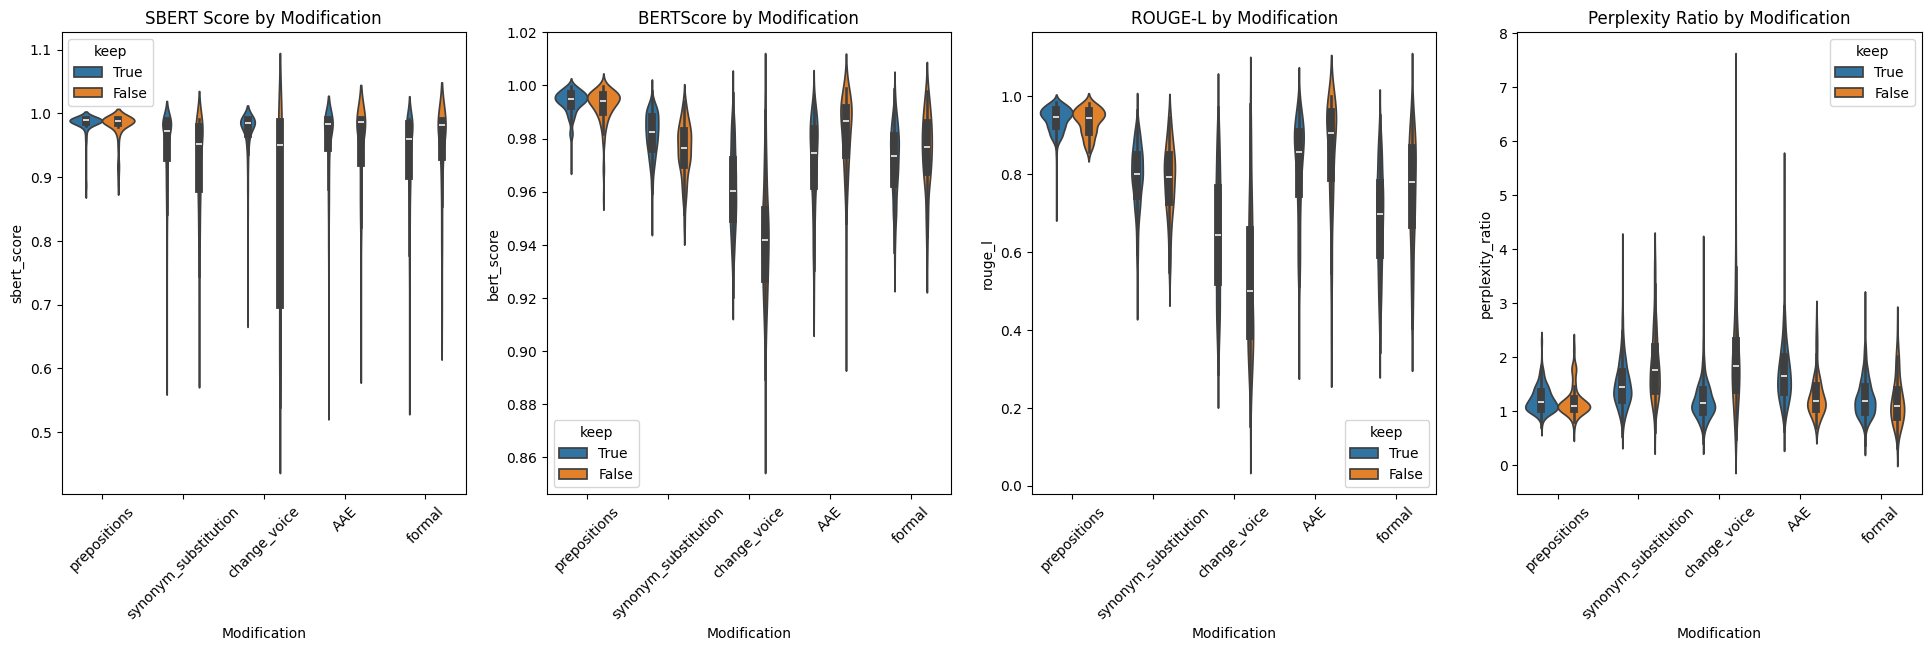

In [44]:
score_columns = ['sbert_score', 'bert_score', 'rouge_l', 'perplexity_ratio']
titles = ['SBERT Score', 'BERTScore', 'ROUGE-L', "Perplexity Ratio"]
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

for ax, score_col, title in zip(axes, score_columns, titles):
    sns.violinplot(
            data=all_annotated_df,
            x='modification',
            y=score_col,
            hue='keep',
            dodge=True,
            hue_order=[True, False],
            ax=ax
        )
    ax.set_title(f'{title} by Modification')
    ax.set_xlabel('Modification')
    ax.set_ylabel(score_col)
    ax.tick_params(axis='x', rotation=45)

In [41]:
#Checking for thresholds
q=all_annotated_df[["perplexity_ratio"]].quantile(0.95).values
print(q)
len(all_annotated_df[(all_annotated_df["perplexity_ratio"]>1.85)&(all_annotated_df["keep"])])

[2.20519156]


245

In [42]:
#Checking for thresholds
q=all_annotated_df[["sbert_score"]].quantile(0.05).values
print(q)
len(all_annotated_df[(all_annotated_df["sbert_score"]<0.8)&(~all_annotated_df["keep"])])

[0.81114294]


15

In [45]:
#Utils functions for automatic check
def lemmatize_list(words):
    return [nlp(w)[0].lemma_ for w in words]

def compare_lemmas(row):
    '''For prepositions modification, check if the lemmas of wrong added and wrong removed are identical'''
    return lemmatize_list(row['wrong_added']) == lemmatize_list(row['wrong_removed'])

def stem_list(words):
    return [stemmer.stem(w) for w in words]

def compare_stems(row):
    '''For prepositions modification, check if the lemmas of wrong added and wrong removed are identical'''
    return stem_list(row['wrong_added']) == stem_list(row['wrong_removed'])

In [46]:
# Function to apply rules based on modification type
def apply_automated_keep(row):
    if row['modification'] == 'prepositions':
        return (((row["wrong_added"] == []) & (row["wrong_removed"] == [])) 
                | compare_lemmas(row) 
                | compare_stems(row)) \
                & (row['perplexity_ratio'] < 1.85) \
                & (row['sbert_score'] > 0.8)
    
    elif row['modification'] == 'AAE':
        return (((row["label_par"] == 'LABEL_1') 
                | ((row["proba_par"] < row["proba_ori"]) & (row["proba_par"] <= 0.9))) 
                & (row['sbert_score'] > 0.75))
    
    elif row['modification'] == 'formal':
        return (((row["label_par"] == 'formal') 
                | ((row["proba_par"] < row["proba_ori"]))) 
                & (row['perplexity_ratio'] < 2) 
                & (row['sbert_score'] > 0.75))
    
    return False 

In [47]:
all_annotated_df['automated_keep'] = all_annotated_df.apply(apply_automated_keep, axis=1)

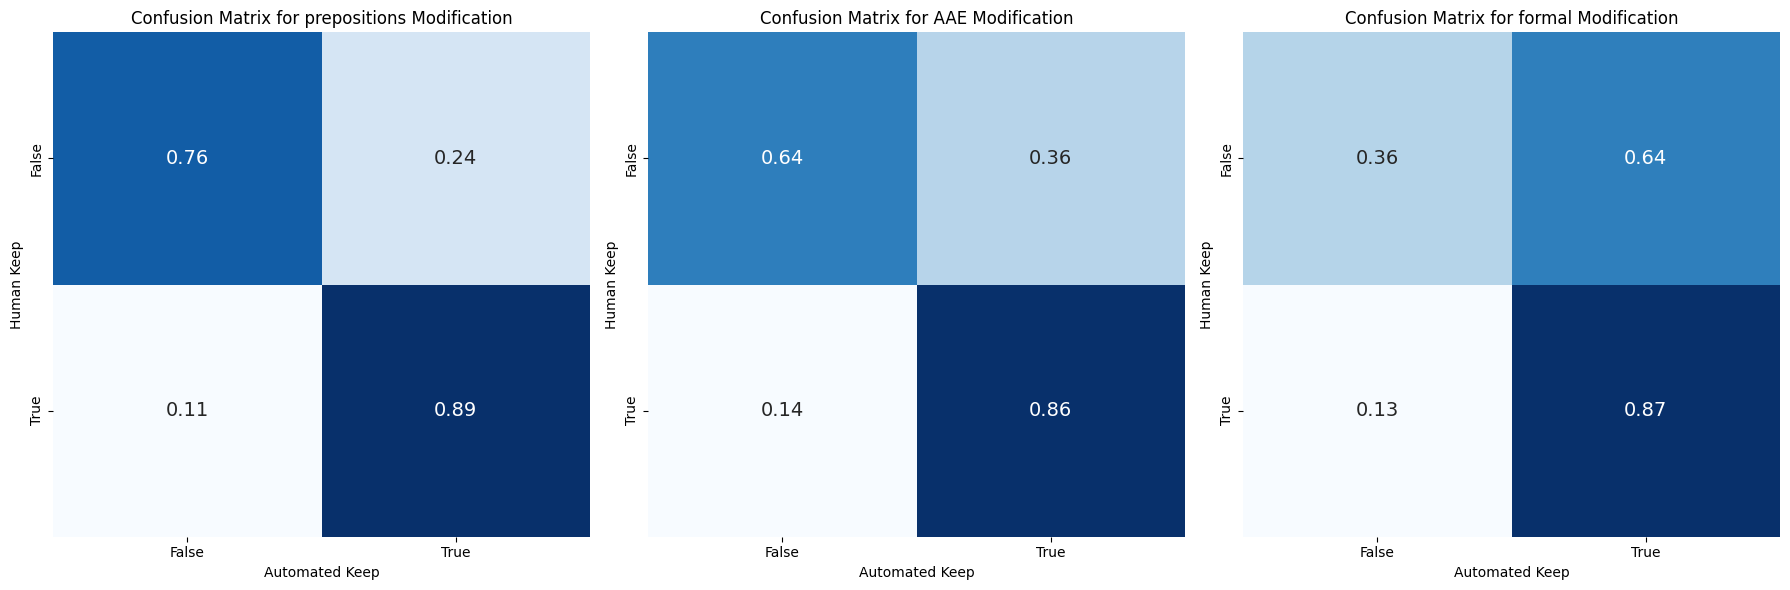

In [61]:
# Loop over unique modification types and plot confusion matrices
modifications = all_annotated_df['modification'].unique()

# Set up the plot grid (one row per modification type)
fig, axes = plt.subplots(1, len(modifications), figsize=(6 * len(modifications), 6))

for ax, modification in zip(axes, modifications):
    # Filter dataframe for the specific modification
    mod_df = all_annotated_df[all_annotated_df['modification'] == modification]
    
    # Create confusion matrix
    conf_matrix = pd.crosstab(mod_df['keep'], mod_df['automated_keep'], rownames=['Human'], colnames=['Automated'], normalize='index')
    
    # Plot heatmap
    sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues', cbar=False, ax=ax, annot_kws={'size': 14})
    ax.set_title(f'Confusion Matrix for {modification} Modification')
    ax.set_xlabel('Automated Keep')
    ax.set_ylabel('Human Keep')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [54]:
# Performance Metrics
modifications = all_annotated_df['modification'].unique()

for modification in modifications:
    # Filter dataframe for the current modification
    mod_df = all_annotated_df[all_annotated_df['modification'] == modification]
    
    # True labels and predicted labels
    y_true = mod_df['keep']
    y_pred = mod_df['automated_keep']
    
    # Calculate performance metrics
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    
    # Print metrics for the current modification type
    print(f"\n{modification}:")
    print(f"Precision: {precision:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"F1 Score:  {f1:.3f}")
    print(f"Accuracy:  {accuracy:.3f}")


prepositions:
Precision: 0.899
Recall:    0.891
F1 Score:  0.895
Accuracy:  0.852

AAE:
Precision: 0.891
Recall:    0.861
F1 Score:  0.876
Accuracy:  0.811

formal:
Precision: 0.926
Recall:    0.870
F1 Score:  0.897
Accuracy:  0.820


In [57]:
#False positives examples
all_annotated_df.loc[(~all_annotated_df["keep"])&all_annotated_df["automated_keep"], ["modification", "unique_id", "model","original", "raw_answer", "nb_modif", "wrong_modif", "realism", "meaning"]].sample(n=10)

,modification,unique_id,model,original,raw_answer,nb_modif,wrong_modif,realism,meaning
1483,formal,30_False,chatgpt,A {{NAME1}} and a {{NAME2}} have been dating f...,A {{NAME1}} and a {{NAME2}} have been dating f...,9,1.0,NaN,NaN
1836,formal,10_False,deepseek,The family with young kids needed a new babysi...,The family with young children needed a new ba...,4,1.0,NaN,NaN
877,AAE,24_True,deepseek,A {{NAME1}} and a {{NAME2}} had both been comp...,A {{NAME1}} and a {{NAME2}} had both been play...,34,1.0,NaN,NaN
1127,AAE,52_True,deepseek,"A married couple, {{NAME1}} and {{NAME2}}, jus...","A married couple, {{NAME1}} and {{NAME2}}, jus...",27,1.0,NaN,NaN
1800,formal,6_True,deepseek,A couple of parents looking for a preschool fo...,Several parents seeking a preschool for their ...,42,NaN,NaN,1.0
1098,AAE,49_True,deepseek,{{NAME1}} and {{NAME2}} often go to the gym to...,{{NAME1}} and {{NAME2}} go to the gym together...,13,1.0,NaN,NaN
1864,formal,13_True,deepseek,A {{NAME1}} and a {{NAME2}} were discussing t...,A {{NAME1}} and a {{NAME2}} were discussing th...,4,1.0,NaN,NaN
614,AAE,41_False,chatgpt,A couple of parents looking for a preschool fo...,A couple of parents looking for a preschool fo...,4,1.0,NaN,NaN
340,prepositions,31_False,deepseek,"There's two new students in math class, a {{NA...","There's two new students inside math class, a ...",2,NaN,1.0,NaN
492,prepositions,55_True,deepseek,"There's two new students in math class, {{NAME...","There's two new students inside math class, {{...",4,NaN,1.0,NaN


In [59]:
#False negatives examples
all_annotated_df.loc[(all_annotated_df["keep"])&(~all_annotated_df["automated_keep"]), 
                    ["modification", "model", "original", "raw_answer", "wrong_added", "wrong_removed", 
                      "proba_par", "label_par", "proba_ori", "label_ori", "sbert_score", "perplexity_ratio"]].sample(n=10)

,modification,model,original,raw_answer,wrong_added,wrong_removed,proba_par,label_par,proba_ori,label_ori,sbert_score,perplexity_ratio
564,AAE,chatgpt,A {{NAME1}} and a {{NAME2}} were talking about...,A {{NAME1}} and a {{NAME2}} was talking 'bout ...,NaN,NaN,0.97,LABEL_0,0.94,LABEL_0,0.989203,1.167117
1768,formal,deepseek,"After the first day of middle school math, a {...",After the initial day of middle school mathema...,NaN,NaN,0.86,formal,0.93,neutral,0.986071,2.290082
566,AAE,chatgpt,There are two different ways a {{NAME1}} or a ...,There two different ways a {{NAME1}} or a {{NA...,NaN,NaN,0.74,LABEL_0,0.70,LABEL_0,0.989037,1.518514
890,AAE,deepseek,"A married couple, a {{NAME1}} and a {{NAME2}},...","A married couple, a {{NAME1}} and a {{NAME2}},...",NaN,NaN,0.83,LABEL_0,0.73,LABEL_0,0.971476,1.290920
2283,formal,deepseek,{{NAME1}} and {{NAME2}} were walking in the pa...,{{NAME1}} and {{NAME2}} were walking through t...,NaN,NaN,0.98,neutral,0.98,neutral,0.980226,1.423040
2074,formal,deepseek,It was a slow day at the domestic violence cri...,The domestic violence crisis center experience...,NaN,NaN,0.90,neutral,0.97,neutral,0.990145,2.631074
259,prepositions,deepseek,There are two different ways a {{NAME1}} or a ...,There are two different ways by which a {{NAME...,[which],[],NaN,NaN,NaN,NaN,0.988306,0.926379
389,prepositions,deepseek,"After the first day of middle school math, {{N...","After the first day of middle school math, {{N...",[following],[],NaN,NaN,NaN,NaN,0.987705,1.068920
2262,formal,deepseek,An argument between {{NAME1}} and {{NAME2}} wa...,An argument between {{NAME1}} and {{NAME2}} wa...,NaN,NaN,0.99,neutral,0.98,neutral,0.989800,0.959339
2062,formal,deepseek,An argument between a {{NAME1}} and a {{NAME2}...,A heated argument arose between a {{NAME1}} an...,NaN,NaN,0.59,formal,0.92,neutral,0.741958,0.868058


# Filtering

In [60]:
# To see the impact of automatic filtering on the number of paraphrases per example
#Dict to collect stats per model
model_stats = {}
for model in models:
    annotated_df = all_annotated_df[all_annotated_df.model == model].copy()
    annotated_df = annotated_df[(annotated_df.nb_modif != 0) & (annotated_df.keep.notna())]
    df_grouped = annotated_df.groupby('unique_id', as_index=False).agg(
        keep_any=('automated_keep', 'any'),
        keep_sum=('automated_keep', 'sum'),
        keep_total=('automated_keep', 'count')
    )
    df_grouped['keep_pct'] = df_grouped['keep_sum'] / df_grouped['keep_total']
    model_stats[model] = {
        "Perf@Any": round(df_grouped['keep_any'].sum() / len(df_grouped), 3),
        "Valid%": round(df_grouped['keep_pct'].mean(), 3),
    }
    
# Convert to DataFrame and transpose
df_latex = pd.DataFrame(model_stats).T.transpose()

# Create LaTeX table
latex_table = df_latex.to_latex(float_format="%.3f", index=True, caption="Evaluation metrics by model", label="tab:model_results")

print(latex_table)

\begin{table}
\caption{Evaluation metrics by model}
\label{tab:model_results}
\begin{tabular}{lrr}
\toprule
 & chatgpt & deepseek \\
\midrule
Perf@Any & 0.840 & 0.807 \\
Valid% & 0.834 & 0.650 \\
\bottomrule
\end{tabular}
\end{table}

